# 0.1 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import missingno as msno
from PIL import Image

import category_encoders as ce

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from imblearn.over_sampling import SMOTE

## 0.1.1 Helper functions

In [3]:

forest = ExtraTreesClassifier(n_jobs=-1, n_estimators=250, verbose=1 ,random_state=0)
        
def feature_importance(X, y):     
    forest.fit(X, y)
    importances = forest.feature_importances_

    df = pd.DataFrame({'feature': X.columns.to_list(), 
                        'importance': importances
                        }).sort_values(by='importance', ascending=False).reset_index(drop=True)    
    return df

def plot_feature_importance(df):
    plt.figure(figsize=(10,6))
    plt.title('Feature Importance')
    plt.ylabel('Features', fontsize=12)
    plt.xlabel('Importance', fontsize=12)
    sns.barplot(data=df, x='importance', y='feature',orient='h', palette='viridis', hue='feature', legend=False)
    plt.show()

def check_imbalance(df: pd.DataFrame)-> pd.DataFrame: 
    total = df.shape[0]
    no_count = df['response'].value_counts().iloc[0]
    yes_count = df['response'].value_counts().iloc[1]

    def highlight(val):
        return 'background-color: red; color: white; font-weight: bold;' if val < 20 else ''

    no_percentage = (no_count/total) * 100
    yes_percentage = 100 - no_percentage

    df_dist = pd.DataFrame({'no_count': no_count,
                            'yes_count': yes_count,
                            'no_percentage': no_percentage,
                            'yes_percentage': yes_percentage
                }, index=[0]).style.map(highlight, subset=['no_percentage','yes_percentage'])

    return df_dist 

## 0.1.2 Loading dataset

In [4]:
raw_train = pd.read_csv('../data/raw/train.csv')

# 1.0 Data description 

## 1.1 Checking dataset shape and columns

In [5]:
raw_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [6]:
raw_train.shape

(381109, 12)

In [7]:
raw_train.columns = [col.lower().replace(' ','_') for col in raw_train.columns]

## 1.2 Checking data types

In [8]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   driving_license       381109 non-null  int64  
 4   region_code           381109 non-null  float64
 5   previously_insured    381109 non-null  int64  
 6   vehicle_age           381109 non-null  object 
 7   vehicle_damage        381109 non-null  object 
 8   annual_premium        381109 non-null  float64
 9   policy_sales_channel  381109 non-null  float64
 10  vintage               381109 non-null  int64  
 11  response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [9]:

raw_train['region_code'] = raw_train['region_code'].astype('int')
raw_train['policy_sales_channel'] = raw_train['policy_sales_channel'].astype('int')
raw_train['gender'] = raw_train['gender'].astype('category')
raw_train['vehicle_damage'] = raw_train['vehicle_damage'].astype('category')

## 1.3 Checking missing or unsupported data 

<Axes: >

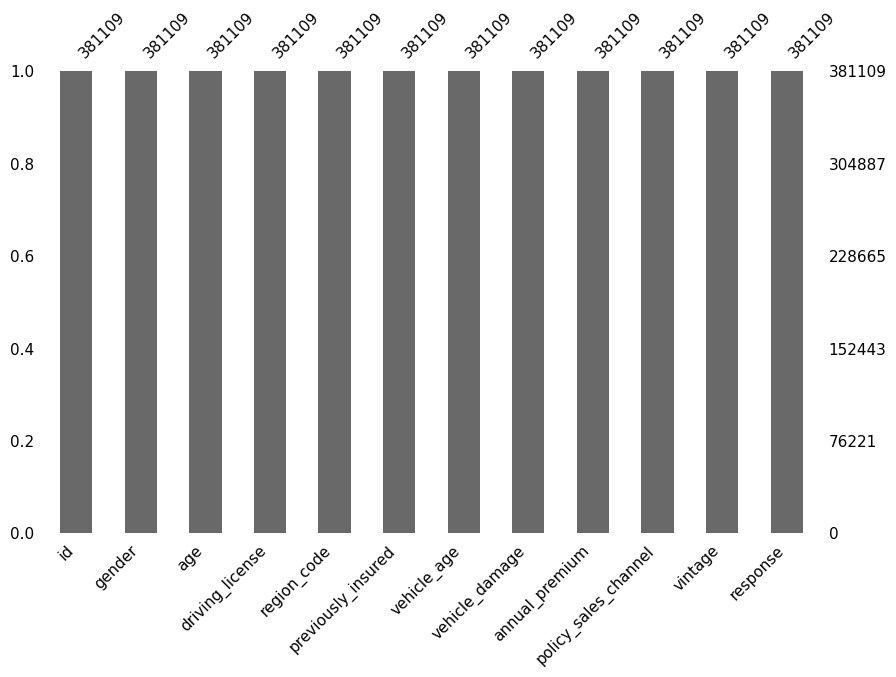

In [10]:
msno.bar(raw_train, figsize=(10,6), fontsize=11)

In [10]:
vehicle_dmg = raw_train['vehicle_damage'].str.count(r'[^a-zA-Z0-9\s]').sum()
gender = raw_train['gender'].astype('str').str.count(r'[^a-zA-Z0-9\s]').sum()

print(f'\'vehicle_damage\' special characters: {vehicle_dmg} \n\'gender\' special characters: {gender}')


'vehicle_damage' special characters: 0 
'gender' special characters: 0


## 1.4 Checking if classes are imbalanced

In [11]:
check_imbalance(raw_train)

,no_count,yes_count,no_percentage,yes_percentage
0,334399,46710,87.743664,12.256336


## 1.5 Descriptive analysis 

In [12]:
num_features = raw_train.select_dtypes(include=['int64','float64'])
cat_features = raw_train.select_dtypes(exclude=['int64','float64', 'datetime64[ns]'])

In [13]:
kurt_skew = num_features.apply(lambda x: x.agg(['kurtosis', 'skew'])).T
df_describe = num_features.describe().T

df_stats = pd.concat([df_describe, kurt_skew], axis=1)
df_stats  

,count,mean,std,min,25%,50%,75%,max,kurtosis,skew
id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0,-1.200000,9.443274e-16
age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0,-0.565655,6.725390e-01
driving_license,381109.0,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0,464.354302,-2.159518e+01
region_code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0,-0.867857,-1.152664e-01
previously_insured,381109.0,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0,-1.971871,1.677471e-01
annual_premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0,34.004569,1.766087e+00
policy_sales_channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0,-0.970810,-9.000081e-01
vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0,-1.200688,3.029517e-03
response,381109.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0,3.298788,2.301906e+00


---

# 2.0 Data Preparation

In [14]:
X_train = raw_train.drop(['id','response'], axis=1)
y_train = raw_train['response'].copy()

## 2.1 Feature Engineering

In [16]:
# Change string entries to snakecase
for col in X_train.select_dtypes(exclude=['int64','float64', 'datetime64[ns]']).columns:
    X_train[col] = X_train[col].str.lower()

In [15]:
# Rename vehicle_age categories
X_train['vehicle_age'] = X_train['vehicle_age'].map({'> 2 Years': 'over_2_years',
                                                     '1-2 Year': '1_to_2_years',
                                                     '< 1 Year': 'under_1_year'
                                                     })

In [17]:
X_train.head()

,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage
0,male,44,1,28,0,over_2_years,yes,40454.0,26,217
1,male,76,1,3,0,1_to_2_years,no,33536.0,26,183
2,male,47,1,28,0,over_2_years,yes,38294.0,26,27
3,male,21,1,11,1,under_1_year,no,28619.0,152,203
4,female,29,1,41,1,under_1_year,no,27496.0,152,39


## 2.2 Encoding

In [18]:
tg_enc_region_code = ce.JamesSteinEncoder(cols=['region_code'])

# One-Hot encoding
X_train = pd.get_dummies(X_train, columns= ['gender'], prefix= 'gender', dtype=int)

# Target encoding (James-Stein) 
X_train['region_code'] = tg_enc_region_code.fit_transform(X= X_train[['region_code']], y= y_train)
joblib.dump(tg_enc_region_code, '../parameters/region_code_james_stein.joblib')

# Label encoding
X_train['vehicle_damage'] = X_train['vehicle_damage'].map({'yes':1,'no':0})

# One-Hot encoding
X_train = pd.get_dummies(X_train, columns= ['vehicle_age'], prefix= 'vehicle_age', dtype=int)

# Frequency encoding
fe_policy_sales_channel = X_train['policy_sales_channel'].value_counts(normalize=True)
X_train['policy_sales_channel'] = X_train['policy_sales_channel'].map(fe_policy_sales_channel)

## 2.3 Rescaling

In [19]:
mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()

X_train['age'] = mms_age.fit_transform(X_train[['age']].values)
joblib.dump(mms_age, '../parameters/age_scaler.joblib')

X_train['vintage'] = mms_vintage.fit_transform(X_train[['vintage']].values)
joblib.dump(mms_vintage, '../parameters/vintage_scaler.joblib')

['../parameters/vintage_scaler.joblib']

## 2.4 Standartization

In [20]:
# annual_premium
ss = StandardScaler()
X_train['annual_premium'] = ss.fit_transform(X_train[['annual_premium']].values)
joblib.dump(ss, '../parameters/annual_premium_scaler.joblib')

['../parameters/annual_premium_scaler.joblib']

## 2.5 Feature Selection

The below cells are commented so its not needed to run the feature selection model everytime. The results are save. 
Uncomment it if you want to try refit the model.

In [ ]:
# Calculate feature importance using extra trees classifier
feat_importance = feature_importance(X_train, y_train)
feat_importance

In [ ]:
# Plot feature importance bar chart
features_plot = plot_feature_importance(feat_importance)

In [ ]:
# Select features with importance greater than 0.015
columns_selected = feat_importance.loc[feat_importance['importance'] > 0.015, 'feature'].to_list()
columns_selected 

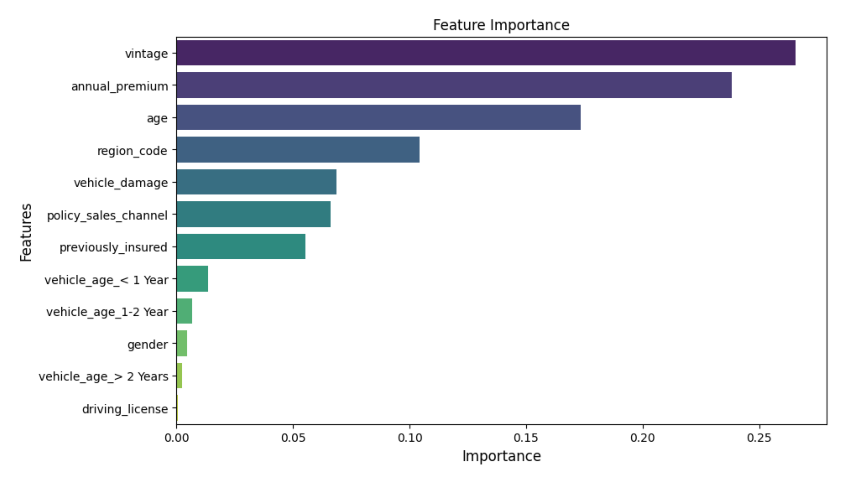

In [24]:
# Saving results of feature importance and the respective plot
features_saved = ['vintage',
                  'annual_premium',
                  'age',
                  'region_code',
                  'vehicle_damage',
                  'policy_sales_channel',
                  'previously_insured']

img = Image.open('../reports/figures/feature_importance.png')
plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.axis('off')
plt.show()

In [27]:
# Saving processed data for modeling
X_train_full = pd.concat([X_train, y_train], axis=1)

X_train_full.to_csv('../data/processed/train.csv', index=False)